In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn')
sns.set(font_scale=1.5) 

%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [2]:
df = pd.read_pickle("../input/wm811k-wafer-map/LSWMD.pkl")

In [3]:
df.info() #dataset check.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


dataset has 47543 lot. Theoretically, there must be 25*47543 waferMap. but last Index is 811456.
Let's check this problem.

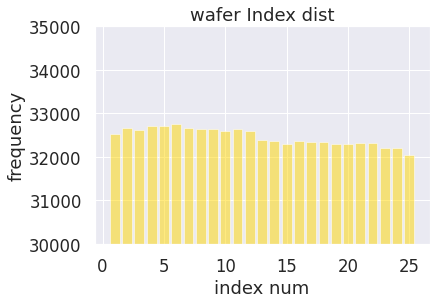

In [6]:
lot_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(lot_index[0], lot_index[1], color='gold', align = 'center', alpha = 0.5)
plt.title("wafer Index dist")
plt.xlabel("index num")
plt.ylabel("frequency")
plt.ylim(30000, 35000)
plt.show()

each index frequency is not equal, but we're not use this column.
so drop waferIndex column.

In [7]:
df = df.drop(['waferIndex'], axis = 1)

In [8]:
#add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
519316,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2,...",515.0,lot32472,[],[],"(25, 27)"
252853,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1382.0,lot15668,[[Training]],[[none]],"(41, 43)"
343767,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2628.0,lot20595,[],[],"(57, 58)"
589760,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",515.0,lot36806,[],[],"(25, 27)"
610148,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot38366,[],[],"(32, 29)"


In [9]:
#df_withlabel : labeled wafer
#df_withpattern : labeled & patterned wafer 
#df_nonpatter : labeled but non-patterned wafer
defined_df = df.loc[df['failureType'] != 0] #failureType !=0
defined_withpattern = defined_df[(defined_df['failureType'] != 'none')]
defined__withpattern = defined_withpattern.reset_index() #patterned index.
defined_nonpattern = defined_df[(defined_df['failureType'] == 'none')] #nonpatterned index
defined_df.shape[0], defined__withpattern.shape[0], defined_nonpattern.shape[0]

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


(172950, 25519, 147431)

In [10]:
defined_df['waferMapDim'].value_counts() #use (26,26) dim

(25, 27)      18781
(26, 26)      14366
(30, 34)      12400
(29, 26)      11751
(27, 25)      10682
              ...  
(41, 39)          1
(122, 104)        1
(54, 54)          1
(109, 111)        1
(43, 133)         1
Name: waferMapDim, Length: 346, dtype: int64

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [12]:
#extract specific dim
def subwafer(data, Dim0, Dim1):
  sw = torch.ones((1, Dim0, Dim1))
  label = list()
  Dim0 = np.size(sw, axis=1)
  Dim1 = np.size(sw, axis=2)
  sub_df = data.loc[data['waferMapDim'] == (Dim0, Dim1)]
  sub_wafer = sub_df['waferMap'].values
  sw = sw.to(DEVICE)
  for i in range(len(sub_df)):
    waferMap = torch.from_numpy(sub_df.iloc[i,:]['waferMap'].reshape(1, Dim0, Dim1))
    waferMap = waferMap.to(DEVICE)
    sw = torch.cat([sw, waferMap]) 
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
  x = sw[1:]
  y = np.array(label).reshape((-1,1))
  del waferMap, sw
  return x, y

In [13]:
x, y = subwafer(defined_df,26,26)

In [14]:
x1, y1 = subwafer(defined_df, 25, 27)
x2, y2 = subwafer(defined_df, 30, 34)

In [15]:
x.shape, y.shape, x1.shape, y1.shape, x2.shape, y2.shape

(torch.Size([14366, 26, 26]),
 (14366, 1),
 torch.Size([18781, 25, 27]),
 (18781, 1),
 torch.Size([12400, 30, 34]),
 (12400, 1))

In [16]:
np.where(y=='Donut')

(array([10686]), array([0]))

Text(0.5, 1.0, 'None')

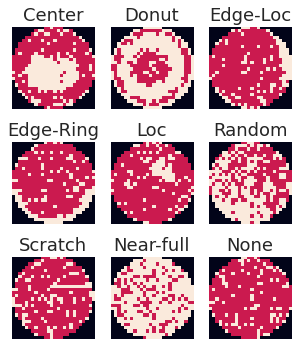

In [17]:
fig, ax = plt.subplots(3,3, figsize = (5,6))
ax[0][0].imshow(x[np.where(y=='Center')[0][20]].to('cpu'))
ax[0][0].set_title("Center")
ax[0][0].axis("off")
ax[0][1].imshow(x[np.where(y=='Donut')[0][0]].to('cpu'))
ax[0][1].axis("off")
ax[0][1].set_title("Donut")
ax[0][2].imshow(x[np.where(y=='Edge-Loc')[0][100]].to('cpu'))
ax[0][2].axis("off")
ax[0][2].set_title("Edge-Loc")
ax[1][0].imshow(x[np.where(y=='Edge-Ring')[0][20]].to('cpu'))
ax[1][0].axis("off")
ax[1][0].set_title("Edge-Ring")
ax[1][1].imshow(x[np.where(y=='Loc')[0][15]].to('cpu'))
ax[1][1].axis("off")
ax[1][1].set_title("Loc")
ax[1][2].imshow(x[np.where(y=='Random')[0][20]].to('cpu'))
ax[1][2].axis("off")
ax[1][2].set_title("Random")
ax[2][0].imshow(x[np.where(y=='Scratch')[0][20]].to('cpu'))
ax[2][0].axis("off")
ax[2][0].set_title("Scratch")
ax[2][1].imshow(x[np.where(y=='Near-full')[0][1]].to('cpu'))
ax[2][1].axis("off")
ax[2][1].set_title("Near-full")
ax[2][2].imshow(x[np.where(y=='none')[0][0]].to('cpu'))
ax[2][2].axis("off")
ax[2][2].set_title("None")

In [18]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [19]:
def resize(data, Dim0, Dim1):
  transPIL = transforms.ToPILImage()
  transTensor = transforms.ToTensor()
  rwm = torch.ones((1,Dim0,Dim1)).to(DEVICE)
  for i in range(len(data)):
    a = transPIL(data[i].int()).resize((Dim0,Dim1))
    a = transTensor(a).reshape((1,Dim0,Dim1)).to(DEVICE)
    rwm = torch.cat([rwm, a])
  x = rwm[1:]
  del rwm
  return x

In [20]:
resized_x1 =resize(x1, 26, 26)
resized_x2 =resize(x2, 26, 26)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:88: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))


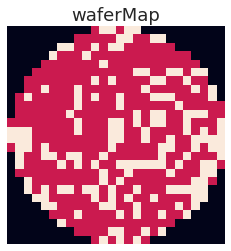

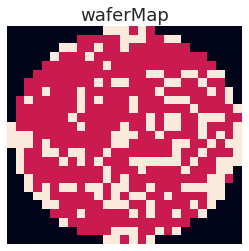

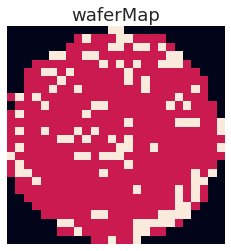

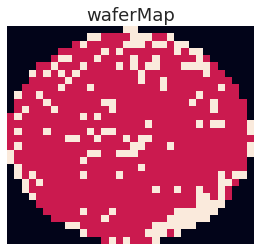

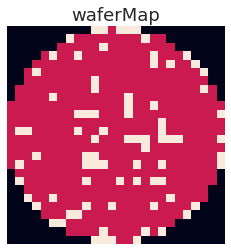

In [21]:
# visualize one of the images in data set
def visualize_image(data, index, pred=False, val=0):
    '''This funtion can be used to visualize the images'''
    Dim0 ,Dim1= np.size(data, axis = 1), np.size(data, axis = 2)
    plt.imshow(data[index].reshape(Dim0,Dim1).cpu().int())
    plt.axis("off")
    plt.title("waferMap")
    plt.show()
visualize_image(resized_x1, 12)
visualize_image(x1, 12)
visualize_image(resized_x2, 12)
visualize_image(x2, 12)
visualize_image(x, 12)

In [22]:
resize_x = torch.cat([resized_x1, resized_x2])

In [23]:
y1 = np.concatenate((y1,y2))

In [24]:
resize_x.shape, y1.shape

(torch.Size([31181, 26, 26]), (31181, 1))

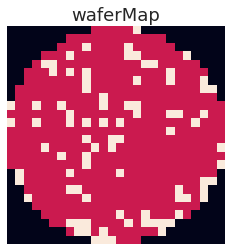

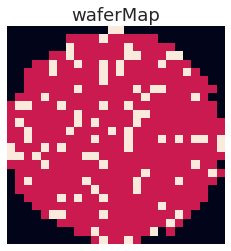

In [25]:
visualize_image(x,12000)
visualize_image(resized_x2,200)

In [26]:
#Convolutional Autoencoder
# parameter
args = {
	'BATCH_SIZE': 32,
        'LEARNING_RATE': 0.001,
        'NUM_EPOCH': 10
        }

In [27]:
x.shape

torch.Size([14366, 26, 26])

In [28]:
train_loader  = torch.utils.data.DataLoader(x, args['BATCH_SIZE'], shuffle=True, drop_last = True)

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

In [30]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                         
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                        
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                      
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                         
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [31]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,0),                 
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,0),                  
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,2,1,0),                 
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,16,2,1,0),                 
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,2,2,2,0),                    
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out



In [32]:
!pip install ../input/torchsummary/torchsummary-1.5.1-py3-none-any.whl

Processing /kaggle/input/torchsummary/torchsummary-1.5.1-py3-none-any.whl


In [33]:
from torchsummary import summary
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)
parameters = list(encoder.parameters())+ list(decoder.parameters())
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=args['LEARNING_RATE'])
summary(encoder,(1,26,26), batch_size=32)
summary(decoder,(256,6,6), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 26, 26]             160
              ReLU-2           [32, 16, 26, 26]               0
       BatchNorm2d-3           [32, 16, 26, 26]              32
            Conv2d-4           [32, 32, 26, 26]           4,640
              ReLU-5           [32, 32, 26, 26]               0
       BatchNorm2d-6           [32, 32, 26, 26]              64
            Conv2d-7           [32, 64, 26, 26]          18,496
              ReLU-8           [32, 64, 26, 26]               0
       BatchNorm2d-9           [32, 64, 26, 26]             128
        MaxPool2d-10           [32, 64, 13, 13]               0
           Conv2d-11          [32, 128, 13, 13]          73,856
             ReLU-12          [32, 128, 13, 13]               0
      BatchNorm2d-13          [32, 128, 13, 13]             256
        MaxPool2d-14            [32, 12

In [34]:
steps = 0
print(x.shape)
losses =[]
total_steps = len(train_loader)
running_loss = 0
iterations = []
for epoch in range(args['NUM_EPOCH']):
    for i,wafer in enumerate(train_loader):
        steps += 1
        wafer = wafer.to(DEVICE).unsqueeze(1).float()
        optimizer.zero_grad()
        output = encoder(wafer)
        output = decoder(output)
        loss = criterion(output, wafer) #autoencoder loss : compare input & output
        running_loss += loss.item()*wafer.size(0)
        loss.backward()
        optimizer.step()
        if steps % total_steps == 0:
            encoder.eval(), decoder.eval()
            print('Epoch: {}/{}'.format(epoch+1, args['NUM_EPOCH']),
                 "=> loss : %.3f"%(running_loss / total_steps))
            steps = 0
            running_loss = 0
            iterations.append(i)
            losses.append(running_loss / total_steps)
            encoder.train(), decoder.train()

torch.Size([14366, 26, 26])
Epoch: 1/10 => loss : 8.001
Epoch: 2/10 => loss : 5.478
Epoch: 3/10 => loss : 2.410
Epoch: 4/10 => loss : 2.243
Epoch: 5/10 => loss : 2.179
Epoch: 6/10 => loss : 2.145
Epoch: 7/10 => loss : 2.119
Epoch: 8/10 => loss : 2.100
Epoch: 9/10 => loss : 2.084
Epoch: 10/10 => loss : 2.070


In [35]:
PATH = "../output"
torch.save({
            'epoch': args['NUM_EPOCH'],
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion
            }, PATH)

In [36]:
np.unique(y)

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype='<U9')

In [37]:
np.where(y=='Donut')

(array([10686]), array([0]))

In [38]:
 with torch.no_grad():
    encoded_x = encoder(x[10686].reshape(1,1,26,26).to(DEVICE))
    noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.35, size = (len(encoded_x),256,6,6))).to(DEVICE))
    noised_decoded_x = decoder(noised_encoded_x.float())
    noised_decoded_x2 = decoder(encoded_x.float())

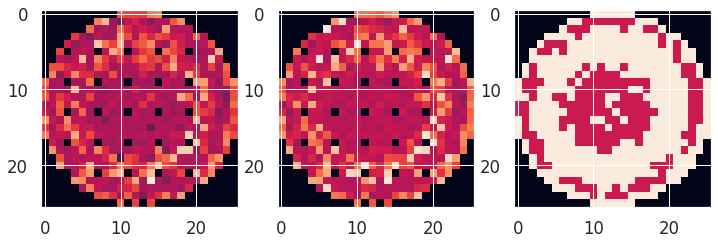

In [39]:
fig, ax = plt.subplots(1,3, figsize = (12,6))
c = noised_decoded_x.cpu().numpy()
ax[0].imshow(c[0][0])
d = noised_decoded_x2.cpu().numpy()
ax[1].imshow(d[0][0])
ax[2].imshow(x[10686].cpu())

In [40]:
# augment function define
def gen_data(data, label):
  Dim0 = np.size(data, axis=1)
  Dim1 = np.size(data, axis=2)
  gen_x = torch.zeros((1, 1, Dim0, Dim1)).to(DEVICE)
  encoded_x = encoder(data.unsqueeze(1).to(DEVICE)).to(torch.device('cpu'))
  with torch.no_grad():
    # dummy array for collecting noised wafer 
    # Make wafer until total # of wafer to 3000
    for i in range((3000//len(data)) + 1):
        noised_encoded_x = (encoded_x + torch.from_numpy(np.random.normal(loc=0, scale=0.3, size = (len(encoded_x),256,6,6)))).to(DEVICE)
        noised_decoded_x = decoder(noised_encoded_x.float())
        noised_decoded_x = np.where(noised_decoded_x.to('cpu').numpy() <0.01, 0, noised_decoded_x.to('cpu').numpy())
        noised_decoded_x = np.where((noised_decoded_x >0.01)&(noised_decoded_x<=1.2), 1, noised_decoded_x)
        noised_decoded_x = np.where(noised_decoded_x > 1.2, 2, noised_decoded_x)
        noised_decoded_x = torch.from_numpy(noised_decoded_x).to(DEVICE)
        gen_x = torch.cat([gen_x, noised_decoded_x], axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    # return date without 1st dummy data.
  return gen_x[1:], gen_y[1:]

In [41]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    gen_x, gen_y = gen_data(x[np.where(y==f)[0]].to(DEVICE), f)
    x = torch.cat([x.to(DEVICE), gen_x.squeeze(1)], axis=0)
    y = np.concatenate((y, gen_y))

In [42]:
print('After Generate resized_wm shape : {}, label_wm shape : {}'.format(x.shape, y.shape))

After Generate resized_wm shape : torch.Size([39023, 26, 26]), label_wm shape : (39023, 1)


In [43]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 3150
Donut : 3002
Edge-Loc : 3552
Edge-Ring : 3038
Loc : 3564
Near-full : 3024
Random : 3108
Scratch : 3096
none : 13489


In [44]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=10489, replace=False)]
Edge_Loc_idx = np.where(y=='Edge-Loc')[0][np.random.choice(len(np.where(y=='Edge-Loc')[0]), size=552, replace=False)]
Loc_idx = np.where(y=='Loc')[0][np.random.choice(len(np.where(y=='Loc')[0]), size=564, replace=False)]
delete_idx = np.concatenate((none_idx,Edge_Loc_idx,Loc_idx))
remove_wm = np.delete(x.to('cpu').numpy(), delete_idx, axis=0)
resized_wm = torch.from_numpy(remove_wm)

In [45]:
label_wm = np.delete(y, delete_idx, axis=0)

In [46]:
for f in faulty_case :
    print('{} : {}'.format(f, len(label_wm[label_wm==f])))

Center : 3150
Donut : 3002
Edge-Loc : 3000
Edge-Ring : 3038
Loc : 3000
Near-full : 3024
Random : 3108
Scratch : 3096
none : 3000


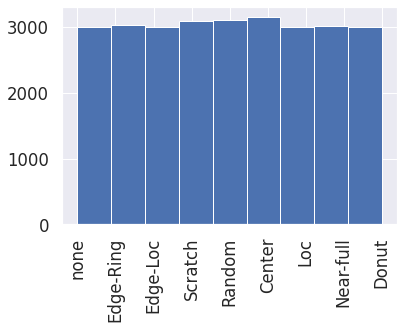

In [47]:
n, bins, patches = plt.hist(label_wm, bins=9)
plt.xticks(rotation=90)
plt.show()

In [48]:
# one-hot-encoding
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i    
    print('i : {}, l : {}'.format(i, l))
def _to_one_hot(y, num_classes):
    scatter_dim = len(y.size())
    y_tensor = y.view(*y.size(), -1)
    zeros = torch.zeros(*y.size(), num_classes, dtype=y.dtype)
    return zeros.scatter(scatter_dim, y_tensor, 1)
label_wm = _to_one_hot(torch.as_tensor(np.int64(label_wm)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


In [49]:
visualdata = torch.utils.data.TensorDataset(resized_wm, label_wm)
resizeLoader = DataLoader(visualdata, shuffle = True)

tensor(0)


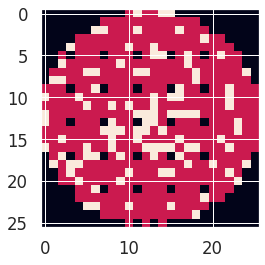

In [50]:
def visual(x):
    images, labels = next(iter(x))
    plt.imshow(images.squeeze(0).to('cpu'))
    print(torch.argmax(labels))
visual(resizeLoader)

In [51]:
from sklearn import model_selection

In [52]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(resized_wm, label_wm , test_size=0.2)
train = torch.utils.data.TensorDataset(train_X,train_Y)
test = torch.utils.data.TensorDataset(test_X,test_Y)
dataset = ConcatDataset([train, test])

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 =nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),#1번째 conv layer : 입력 층 3, 출력 32, Relu, Poolling으로 MAX 직용.
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #2번째 conv layer : 입력 층 32, 출력 64, Relu, Poolling으로 MAX 직용.
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #3번째 conv layer : 입력 층 64, 출력 128, Relu, Polling으로 Max 적용.
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True) # fully connected, 
        nn.init.kaiming_uniform_(self.fc1.weight)
        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU())
        self.fc2 = nn.Linear(625, 9, bias=True) #오류패턴 9개로 출력 9
        nn.init.kaiming_uniform_(self.fc2.weight)      
        
    def printout(self, x):
        out = self.layer1(x)
        print(out)
        out = self.layer2(out)
        print(out)
        out = self.layer3(out)
        print(out)
        out = out.view(out.size(0), -1)   # fully conntect를위해 flatten을 함.
        out = self.layer4(out)
        print(out)
        out = self.fc2(out)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # fully conntect를위해 flatten을 함.
        out = self.layer4(out)
        out = self.fc2(out)
        return out    

In [54]:
CNN = CNN().to(DEVICE)
print(CNN)
summary(CNN,(1,26,26), batch_size=256)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=204

In [55]:
args = {
	'BATCH_SIZE': 32,
        'LEARNING_RATE': 0.007,
        'NUM_EPOCH': 10
        }

In [56]:
criterion = torch.nn.CrossEntropyLoss().to(DEVICE) # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(CNN.parameters(), lr=args['LEARNING_RATE'])
torch.manual_seed(42)
splits = KFold(n_splits=5, shuffle = True, random_state = 42)
foldperf={}

In [57]:
def train_epoch(model, dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE).unsqueeze(1), labels.to(DEVICE).reshape(args['BATCH_SIZE'], 9)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        train_correct += (predictions == labels).sum().item()
    print(train_correct)
    return train_loss,train_correct
  
def valid_epoch(model,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:
        images,labels = images.to(DEVICE).unsqueeze(1), labels.to(DEVICE).reshape(args['BATCH_SIZE'],9)
        output = model(images)
        labels = torch.argmax(labels, dim=1)
        loss=loss_fn(output,labels)
        valid_loss+=loss.item() * images.size(0)
        predictions = torch.argmax(output, 1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [58]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=train_sampler, drop_last=True)
    test_loader = DataLoader(dataset, batch_size=args['BATCH_SIZE'], sampler=test_sampler, drop_last=True)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(args['NUM_EPOCH']):
        train_loss, train_correct=train_epoch(CNN,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(CNN,test_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             args['NUM_EPOCH'],
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

  

Fold 1
16788
Epoch:1/10 AVG Training Loss:0.949 AVG Test Loss:0.150 AVG Training Acc 76.54 % AVG Test Acc 95.28 %
21064
Epoch:2/10 AVG Training Loss:0.123 AVG Test Loss:0.090 AVG Training Acc 96.03 % AVG Test Acc 96.75 %
21464
Epoch:3/10 AVG Training Loss:0.068 AVG Test Loss:0.122 AVG Training Acc 97.86 % AVG Test Acc 96.01 %
21623
Epoch:4/10 AVG Training Loss:0.044 AVG Test Loss:0.041 AVG Training Acc 98.58 % AVG Test Acc 98.61 %
21610
Epoch:5/10 AVG Training Loss:0.047 AVG Test Loss:0.064 AVG Training Acc 98.52 % AVG Test Acc 97.90 %
21698
Epoch:6/10 AVG Training Loss:0.035 AVG Test Loss:0.039 AVG Training Acc 98.92 % AVG Test Acc 98.32 %
21724
Epoch:7/10 AVG Training Loss:0.030 AVG Test Loss:0.042 AVG Training Acc 99.04 % AVG Test Acc 98.71 %
21695
Epoch:8/10 AVG Training Loss:0.031 AVG Test Loss:0.037 AVG Training Acc 98.91 % AVG Test Acc 98.85 %
21699
Epoch:9/10 AVG Training Loss:0.035 AVG Test Loss:0.028 AVG Training Acc 98.93 % AVG Test Acc 99.00 %
21765
Epoch:10/10 AVG Training

In [59]:
torch.save(CNN.state_dict(),'../output')  

In [60]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=5
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     

Performance of 5 fold cross validation
Average Training Loss: 0.043 	 Average Test Loss: 0.033 	 Average Training Acc: 98.81 	 Average Test Acc: 98.87


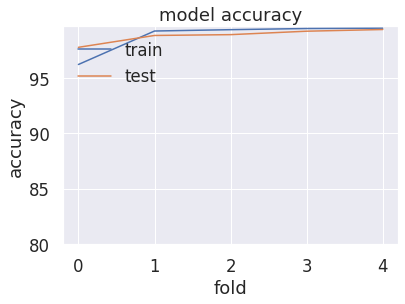

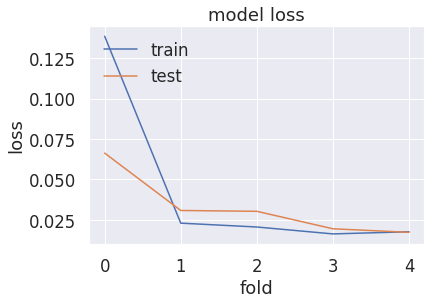

In [61]:
# accuracy plot 
plt.plot(ta_f)
plt.plot(testa_f)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.ylim(80)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(tl_f)
plt.plot(testl_f)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('fold')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 26, 26).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(9), ps)
    ax2.set_aspect(2)
    ax2.set_yticks(np.arange(9))
    ax2.set_yticklabels(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none'])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 15)

    plt.tight_layout()

In [63]:
for i, l in enumerate(faulty_case):
    y1[y1==l] = i    
    print('i : {}, l : {}'.format(i, l))
y1 = _to_one_hot(torch.as_tensor(np.int64(y1)), num_classes=9)

i : 0, l : Center
i : 1, l : Donut
i : 2, l : Edge-Loc
i : 3, l : Edge-Ring
i : 4, l : Loc
i : 5, l : Near-full
i : 6, l : Random
i : 7, l : Scratch
i : 8, l : none


In [64]:
resizedata = torch.utils.data.TensorDataset(resize_x, y1)
resizeLoader = DataLoader(resizedata, shuffle = True)

[  1.8854647 -42.381573   -4.210463  -15.16202    -6.0588303 -21.258684
 -11.021199  -12.237286    7.7787027]
predict: 8 true: 8
[ -6.2826133 -61.49319   -11.107256  -26.600355  -11.261696  -39.245102
 -25.08621    -4.4660454  14.386232 ]
predict: 8 true: 8


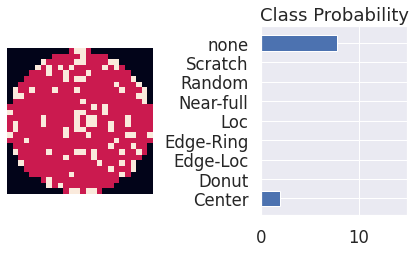

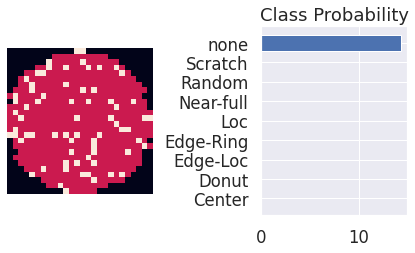

In [65]:
%matplotlib inline
def make_prediction(data):
    images, labels = next(iter(data))
    # Turn off gradients to speed up this part
    images = images.to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        ps = CNN(images).detach().cpu().numpy()[0]
        print(ps)
        print('predict: {} true: {}'.format(np.argmax(ps),torch.argmax(labels[0])))
    # Output of the network are log-probabilities, need to take exponential for probabilities
    view_classify(images.view(1, 26, 26).cpu(), ps)
make_prediction(resizeLoader)
make_prediction(resizeLoader)

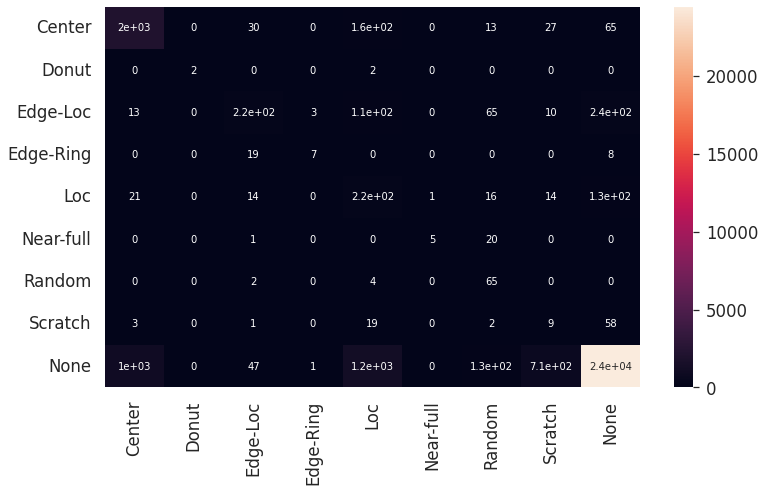

In [66]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for images, labels in resizeLoader:
            images = images.to(DEVICE).unsqueeze(0)
            ps = np.argmax(CNN(images).detach().cpu().numpy()[0])
            y_pred.append(ps) # Save Prediction
            labels = np.argmax(labels[0])
            y_true.append(labels) # Save Truth
# constant for classes
    classes = ('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'None')
# Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)

In [67]:
np.where(np.argmax(y1, axis=2) == 1)

(array([20928, 22274, 29794, 30043]), array([0, 0, 0, 0]))

[-55.239742   31.61481    -1.7247177 -99.26976   -16.165897  -35.384705
   9.081288  -64.14852   -28.426683 ]
predict: 1 true: 1


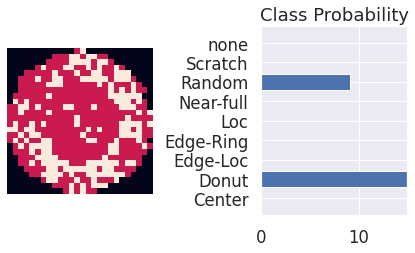

In [68]:
#i : 0, l : Center
#i : 1, l : Donut
#i : 2, l : Edge-Loc
#i : 3, l : Edge-Ring
#i : 4, l : Loc
#i : 5, l : Near-full
#i : 6, l : Random
#i : 7, l : Scratch
#i : 8, l : none

def make_predict(num):
    images, labels = resize_x[num], y1[num]
    # Turn off gradients to speed up this part
    images = images.to(DEVICE).unsqueeze(0)
    images = images.to(DEVICE).unsqueeze(0)
    with torch.no_grad():
        ps = CNN(images).detach().cpu().numpy()[0]
        print(ps)
        print('predict: {} true: {}'.format(np.argmax(ps),torch.argmax(labels[0])))
    # Output of the network are log-probabilities, need to take exponential for probabilities
    view_classify(images.view(1, 26, 26).cpu(), ps)
make_predict(29794)

In [69]:
for f in range(0,9) :
    print('{} : {}'.format(f, len(y1[np.argmax(y1, 2)==f])))

0 : 2309
1 : 4
2 : 661
3 : 34
4 : 413
5 : 26
6 : 71
7 : 92
8 : 27571


In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.87      0.75      2309
           1       1.00      0.50      0.67         4
           2       0.66      0.33      0.44       661
           3       0.64      0.21      0.31        34
           4       0.13      0.53      0.20       413
           5       0.83      0.19      0.31        26
           6       0.21      0.92      0.34        71
           7       0.01      0.10      0.02        92
           8       0.98      0.89      0.93     27571

    accuracy                           0.87     31181
   macro avg       0.57      0.50      0.44     31181
weighted avg       0.93      0.87      0.89     31181

